#  Web Scraping Samsung Galaxy S21 Ultra

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
import time
from datetime import datetime
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from urllib.request import urlopen
from bs4 import BeautifulSoup as bs
import requests

In [20]:
wm_title=[]
wm_date = []
wm_content = []
wm_rating = []

for i in range(1,150):

  link = "https://www.amazon.in/Samsung-Galaxy-Smartphone-Titanium-Storage/product-reviews/B0CS5Y7H6T/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews="+str(i)
  response = requests.get(link)
  soup = bs(response.content,"html.parser")# creating soup object to iterate over the extracted content

  # extracting Review Title
  title = soup.find_all('a',class_='review-title-content')
  review_title = []
  for i in range(0,len(title)):
      review_title.append(title[i].get_text())
  review_title[:] = [titles.lstrip('\n') for titles in review_title]
  review_title[:] = [titles.rstrip('\n') for titles in review_title]
  wm_title = wm_title + review_title

  ## Extracting Ratings
  rating = soup.find_all('i',class_='review-rating')
  review_rating = []
  for i in range(2,len(rating)):
      review_rating.append(rating[i].get_text())
  #review_rating.pop(0)
  #review_rating.pop(0)
  review_rating[:] = [reviews.rstrip(' out of 5 stars') for reviews in review_rating]
  wm_rating = wm_rating + review_rating

  #Extracting Content of review
  review = soup.find_all("span",{"data-hook":"review-body"})
  review_content = []
  for i in range(0,len(review)):
      review_content.append(review[i].get_text())
  review_content[:] = [reviews.lstrip('\n') for reviews in review_content]
  review_content[:] = [reviews.rstrip('\n') for reviews in review_content]
  wm_content = wm_content + review_content

  #Extracting dates of reviews
  dates = soup.find_all('span',class_='review-date')
  review_dates = []
  for i in range(2,len(rating)):
      review_dates.append(dates[i].get_text())
  review_dates[:] = [reviews.lstrip('Reviewed in India on') for reviews in review_dates]
  #review_dates.pop(0)
  #review_dates.pop(0)
  wm_date  = wm_date + review_dates


In [21]:
print(len(wm_title))
print(len(wm_rating))
print(len(wm_content))
print(len(wm_date))

90
90
90
90


In [22]:
df = pd.DataFrame()
df['Title'] = wm_title
df['Ratings'] = wm_rating
df['Comments'] = wm_content
df['Date'] = wm_date

df.head(5)

,Title,Ratings,Comments,Date
0,5.0 out of 5 stars\nOne of the best smartphone...,5.0,Booked my 12+512gb version as soon as it was l...,8 March 2024
1,5.0 out of 5 stars\nWhat a mobile device it is...,5.0,What is there not to like in the S24 Ultra? Bu...,8 March 2024
2,4.0 out of 5 stars\nGood display & features bu...,4.0,"Good display & features, but price is very hig...",7 March 2024
3,5.0 out of 5 stars\nNoch top camera,5.0,Best camera .. better than. I phone 15 pro max,14 March 2024
4,5.0 out of 5 stars\nAmazing device,5.0,Amazing colour and amazing design and amazing ...,6 March 2024


In [23]:
df.head(2)

,Title,Ratings,Comments,Date
0,5.0 out of 5 stars\nOne of the best smartphone...,5.0,Booked my 12+512gb version as soon as it was l...,8 March 2024
1,5.0 out of 5 stars\nWhat a mobile device it is...,5.0,What is there not to like in the S24 Ultra? Bu...,8 March 2024


In [24]:
df['Date'] = pd.to_datetime(df['Date'])
df['Ratings'] = df['Ratings'].astype(float)
df.head(2)

,Title,Ratings,Comments,Date
0,5.0 out of 5 stars\nOne of the best smartphone...,5.0,Booked my 12+512gb version as soon as it was l...,2024-03-08
1,5.0 out of 5 stars\nWhat a mobile device it is...,5.0,What is there not to like in the S24 Ultra? Bu...,2024-03-08


In [25]:
from nltk.corpus import wordnet

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

import string
import nltk
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [26]:
def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

In [27]:
# clean text data
df["Comments"] = df["Comments"].apply(lambda x: clean_text(x))

In [28]:
df['Title'] = df['Title'].astype(str)
df['Title'] = df['Title'].apply(lambda x: clean_text(x))

In [29]:
df.head()

,Title,Ratings,Comments,Date
0,stars\none best smartphones available,5.0,book version soon launch use month here's exce...,2024-03-08
1,stars\nwhat mobile device beautiful beast,5.0,like ultra happy flat screen time around enoug...,2024-03-08
2,stars\ngood display feature price high,4.0,good display feature price high mobile buy sin...,2024-03-07
3,stars\nnoch top camera,5.0,best camera well phone pro max,2024-03-14
4,stars\namazing device,5.0,amaze colour amaze design amazing performance ...,2024-03-06


In [30]:
#  add sentiment anaylsis columns
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
df["sentiments"] = df["Comments"].apply(lambda x: sid.polarity_scores(x))
df = pd.concat([df.drop(['sentiments'], axis=1), df['sentiments'].apply(pd.Series)], axis=1)
'''
sid = SentimentIntensityAnalyzer()
df["sentiments_title"] = df["Title"].apply(lambda x: sid.polarity_scores(x))
df = pd.concat([df.drop(['sentiments_title'], axis=1), df['sentiments_title'].apply(pd.Series)], axis=1)
'''
df

,Title,Ratings,Comments,Date,neg,neu,pos,compound
0,stars\none best smartphones available,5.0,book version soon launch use month here's exce...,2024-03-08,0.056,0.743,0.201,0.9889
1,stars\nwhat mobile device beautiful beast,5.0,like ultra happy flat screen time around enoug...,2024-03-08,0.000,0.630,0.370,0.9337
2,stars\ngood display feature price high,4.0,good display feature price high mobile buy sin...,2024-03-07,0.000,0.865,0.135,0.6486
3,stars\nnoch top camera,5.0,best camera well phone pro max,2024-03-14,0.000,0.388,0.612,0.7430
4,stars\namazing device,5.0,amaze colour amaze design amazing performance ...,2024-03-06,0.089,0.197,0.714,0.9287
...,...,...,...,...,...,...,...,...
85,stars\nvery nice product,5.0,useful ram size increase hand set could superc...,2024-03-03,0.000,0.376,0.624,0.8910
86,stars\npoor product,1.0,many market do many camera great compare iphon...,2024-03-12,0.062,0.737,0.200,0.7184
87,stars\nsamsung ultra 💥💥💥,5.0,samsung ultra big android smartphone,2024-03-04,0.000,1.000,0.000,0.0000
88,stars\nok,4.0,"display curve display like previous model,batt...",2024-03-19,0.000,0.737,0.263,0.3612


In [31]:
# add number of characters column
df["nb_chars"] = df["Comments"].apply(lambda x: len(x))

# add number of words column
df["nb_words"] = df["Comments"].apply(lambda x: len(x.split(" ")))

''''
# add number of characters column
df["nb_chars_title"] = df["Title"].apply(lambda x: len(x))

# add number of words column
df["nb_words_title"] = df["Title"].apply(lambda x: len(x.split(" ")))
'''

'\'\n# add number of characters column\ndf["nb_chars_title"] = df["Title"].apply(lambda x: len(x))\n\n# add number of words column\ndf["nb_words_title"] = df["Title"].apply(lambda x: len(x.split(" ")))\n'

In [32]:
# create doc2vec vector columns
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(df["Comments"].apply(lambda x: x.split(" ")))]

# train a Doc2Vec model with our text data
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

# transform each Comment into a vector data
doc2vec_df = df["Comments"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
df = pd.concat([df, doc2vec_df], axis=1)

'''
# transform each Title into a vector data
doc2vec_df_title = df["Title"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df_title.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
df = pd.concat([df, doc2vec_df_title], axis=1)
'''

'\n# transform each Title into a vector data\ndoc2vec_df_title = df["Title"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)\ndoc2vec_df_title.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]\ndf = pd.concat([df, doc2vec_df_title], axis=1)\n'

In [33]:
# add tf-idfs columns
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df = 10)
tfidf_result = tfidf.fit_transform(df["Comments"]).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names_out())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = df.index
df = pd.concat([df, tfidf_df], axis=1)
df

'''
##TF-IDF for Titles
tfidf = TfidfVectorizer(min_df = 10)
tfidf_result = tfidf.fit_transform(df["Title"]).toarray()
tfidf_df_title = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
tfidf_df_title.columns = ["word_" + str(x) for x in tfidf_df_title.columns]
tfidf_df_title.index = df.index
df = pd.concat([df, tfidf_df_title], axis=1)
'''

'\n##TF-IDF for Titles\ntfidf = TfidfVectorizer(min_df = 10)\ntfidf_result = tfidf.fit_transform(df["Title"]).toarray()\ntfidf_df_title = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())\ntfidf_df_title.columns = ["word_" + str(x) for x in tfidf_df_title.columns]\ntfidf_df_title.index = df.index\ndf = pd.concat([df, tfidf_df_title], axis=1)\n'

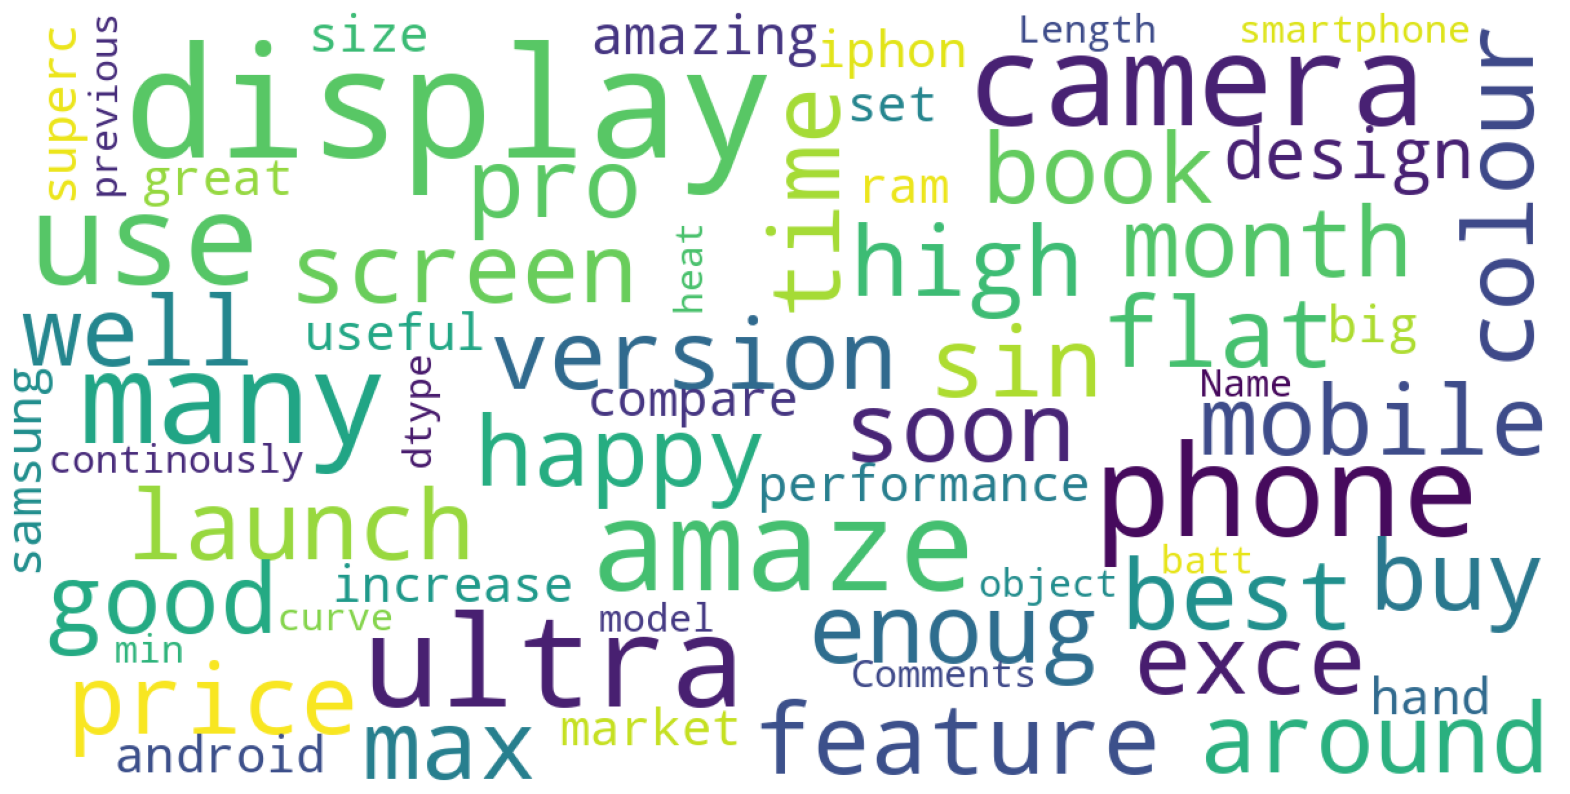

In [34]:

from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40,
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()

# print wordcloud
show_wordcloud(df["Comments"])

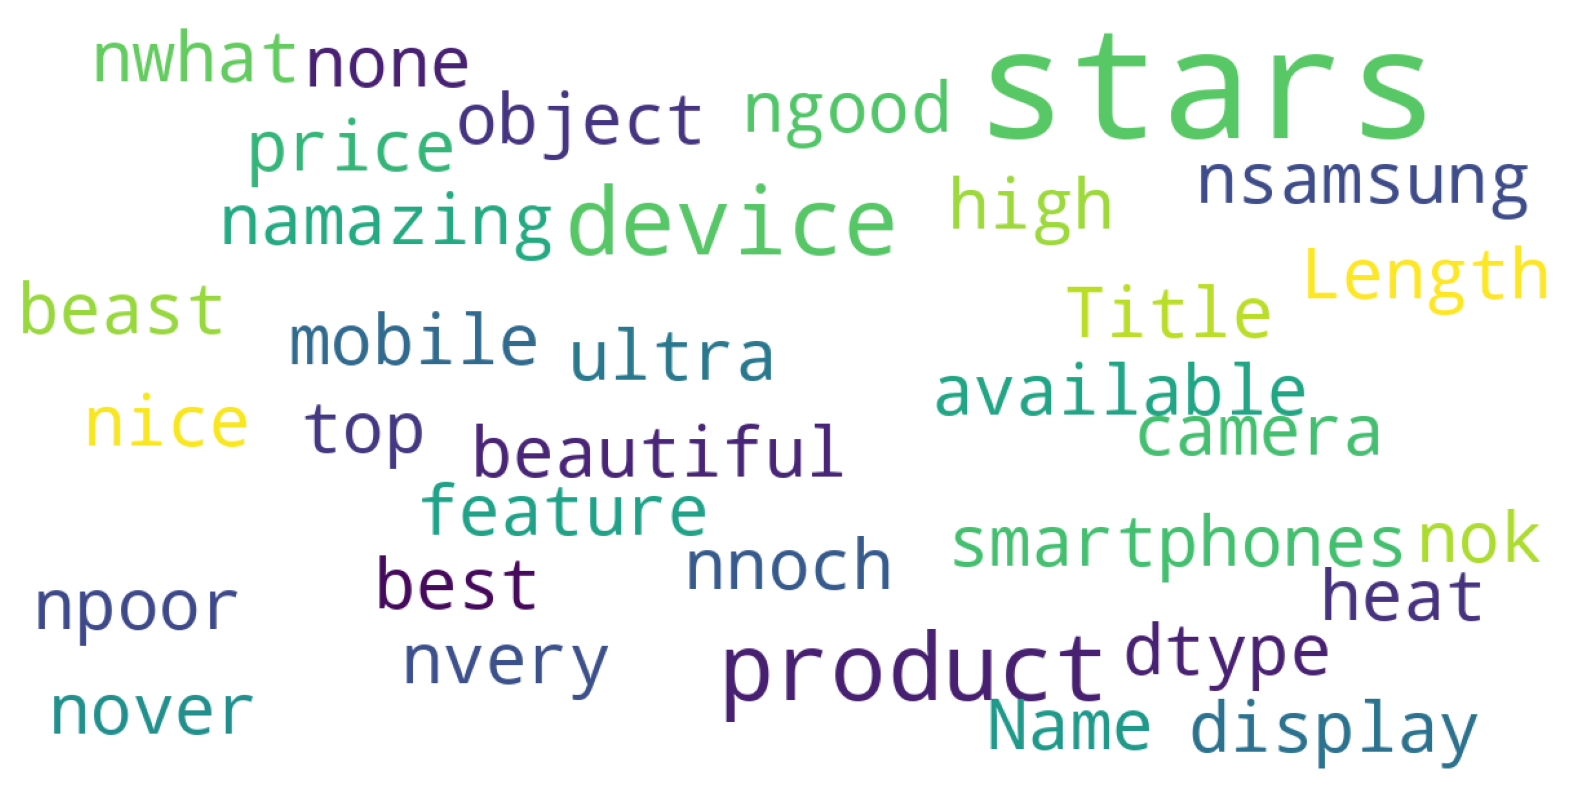

In [35]:
# print wordcloud
show_wordcloud(df["Title"])

In [36]:
df.head(2)

,Title,Ratings,Comments,Date,neg,neu,pos,compound,nb_chars,nb_words,...,word_samsung,word_screen,word_set,word_since,word_smartphone,word_time,word_ultra,word_use,word_well,word_without
0,stars\none best smartphones available,5.0,book version soon launch use month here's exce...,2024-03-08,0.056,0.743,0.201,0.9889,1372,214,...,0.198818,0.234205,0.0,0.000000,0.234205,0.234205,0.066273,0.265091,0.078068,0.078068
1,stars\nwhat mobile device beautiful beast,5.0,like ultra happy flat screen time around enoug...,2024-03-08,0.000,0.630,0.370,0.9337,197,28,...,0.000000,0.457143,0.0,0.228571,0.000000,0.228571,0.388072,0.194036,0.000000,0.000000


In [37]:
# highest positive sentiment reviews (with more than 5 words)
df[df["nb_words"] >= 5].sort_values("pos", ascending = False)[["Comments", "pos"]].head(10)

,Comments,pos
24,amaze colour amaze design amazing performance ...,0.714
44,amaze colour amaze design amazing performance ...,0.714
54,amaze colour amaze design amazing performance ...,0.714
4,amaze colour amaze design amazing performance ...,0.714
84,amaze colour amaze design amazing performance ...,0.714
34,amaze colour amaze design amazing performance ...,0.714
64,amaze colour amaze design amazing performance ...,0.714
74,amaze colour amaze design amazing performance ...,0.714
14,amaze colour amaze design amazing performance ...,0.714
15,useful ram size increase hand set could superc...,0.624


In [38]:
# lowest negative sentiment reviews (with more than 5 words)
df[df["nb_words"] >= 5].sort_values("neg", ascending = False)[["Comments", "neg"]].head(10)

,Comments,neg
54,amaze colour amaze design amazing performance ...,0.089
4,amaze colour amaze design amazing performance ...,0.089
44,amaze colour amaze design amazing performance ...,0.089
64,amaze colour amaze design amazing performance ...,0.089
84,amaze colour amaze design amazing performance ...,0.089
34,amaze colour amaze design amazing performance ...,0.089
24,amaze colour amaze design amazing performance ...,0.089
74,amaze colour amaze design amazing performance ...,0.089
14,amaze colour amaze design amazing performance ...,0.089
16,many market do many camera great compare iphon...,0.062


In [39]:
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df.head(2)

,Title,Ratings,Comments,Date,neg,neu,pos,compound,nb_chars,nb_words,...,word_set,word_since,word_smartphone,word_time,word_ultra,word_use,word_well,word_without,Month,Year
0,stars\none best smartphones available,5.0,book version soon launch use month here's exce...,2024-03-08,0.056,0.743,0.201,0.9889,1372,214,...,0.0,0.000000,0.234205,0.234205,0.066273,0.265091,0.078068,0.078068,3,2024
1,stars\nwhat mobile device beautiful beast,5.0,like ultra happy flat screen time around enoug...,2024-03-08,0.000,0.630,0.370,0.9337,197,28,...,0.0,0.228571,0.000000,0.228571,0.388072,0.194036,0.000000,0.000000,3,2024


In [40]:
df_recent = df[(df['Year']== 2020) & (df['Month'] != 8)]
df_recent.head(2)

,Title,Ratings,Comments,Date,neg,neu,pos,compound,nb_chars,nb_words,...,word_set,word_since,word_smartphone,word_time,word_ultra,word_use,word_well,word_without,Month,Year
